In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import numpy as np 
import pathlib

# Importing utitility functions for training
from PT_files.model import DnCNN_2k, DnCNN_B, DnCNN
from PT_files.Dataset import Img_Dataset, Large_Img_Dataset
import PT_files.preprocess_data as ppd
import PT_files.save_load as sl
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

Using cuda device


In [2]:
data_6k = sl.NERSC_load('test_data70-6000.npy')

In [3]:
# def grid_window(dataset,
#                 model,
#                 model_params,
#                 samp_idx,
#                 h_start,
#                 h_end,
#                 w_start,
#                 w_end):
    
#     """
#     Function to calculate a specified sized inference window.
    
#     Parameters:
#     -----------
#     dataset: np.array
#         Dataset of coupled noisy & clean images of full 6k images
#     model: Pytorch model
#         DnCNN
#     model_params: str
#         Models parameters for the 2k image trained model
#     samp_idx: int
#         Sample index to select which of the test images to be used for 
#         inference
#     h_start: int
#         The height starting index of the inference window.
#         E.g. It would be the origin for the y-coord in a 2-D plot
#     h_end: int
#         The height ending index of the inference window.
#         E.g. It would be the end of the y-axis for the y-coord 
#         in a 2-D plot
#     w_start: int
#         The horizontal starting index of the inference window.
#         E.g. It would be the origin for the x-coord in a 2-D plot
#     w_end: int
#         The horizontal ending index of the inference window.
#         E.g. It would be the end of the x-axis for the x-coord 
#         in a 2-D plot
   
        
#     Returns:
#     --------
#     full: np.array
#         Array of the models output over the window region.
#     count: np.array
#         Array of 1's that keeps track of which pixels have had
#         inferenced done upon them. This is so later on averaging can
#         be done for pixels that had overlapping inference window
#         calculations.
#     """
    
#     full = np.empty((1, 1, 6000, 6000))
#     count = np.empty((1, 1, 6000, 6000))
    
#     noise_data = dataset[0]
#     params_name = model_params
    
#     current_dir = pathlib.Path().resolve()
#     model_params_path = current_dir / 'Model_params'
#     assert model_params_path.exists()
#     model_path = model_params_path / params_name
#     # print('Check pt 1')
    
#     model = model()
#     model.to(device)
#     model.load_state_dict(torch.load(str(model_path)))
#     model.eval()
#     # print('Check pt 2')

    
#     with torch.no_grad():
        
#         torch.cuda.empty_cache()
#         test_noise = torch.as_tensor(noise_data[samp_idx:samp_idx+1, :, h_start:h_end, w_start:w_end])
#         test_noise = test_noise.to(device)
#         # print('Check pt 3')

        
#         output = model(test_noise)
#         resid_img = output.cpu().detach().numpy()
#         # print('Check pt 4')

        
#         full[:, :, h_start:h_end, w_start:w_end] += resid_img
#         count[:, :, h_start:h_end, w_start:w_end] += 1
#         print('Run finished')
        
#     return full, count

In [4]:
# full_c1, count_c1 = grid_window(dataset=data_6k,
#                                         model=DnCNN,
#                                         model_params="2k_model_bs32_e200.pth",
#                                         samp_idx=0,
#                                         h_start=1000,
#                                         h_end=3000,
#                                         w_start=1000,
#                                         w_end=3000)

In [5]:
# 5550*9

In [6]:
def grid_window(dataset,
                model,
                model_params,
                samp_idx,
                h_start,
                h_end,
                w_start,
                w_end):
    
    """
    Function to calculate a specified sized inference window.
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    h_start: int
        The height starting index of the inference window.
        E.g. It would be the origin for the y-coord in a 2-D plot
    h_end: int
        The height ending index of the inference window.
        E.g. It would be the end of the y-axis for the y-coord 
        in a 2-D plot
    w_start: int
        The horizontal starting index of the inference window.
        E.g. It would be the origin for the x-coord in a 2-D plot
    w_end: int
        The horizontal ending index of the inference window.
        E.g. It would be the end of the x-axis for the x-coord 
        in a 2-D plot
   
        
    Returns:
    --------
    full: np.array
        Array of the models output over the window region.
    count: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
    full = np.empty((1, 1, 6000, 6000))
    count = np.empty((1, 1, 6000, 6000))
    
    noise_data = dataset[0]
    params_name = model_params
    
    current_dir = pathlib.Path().resolve()
    model_params_path = current_dir / 'Model_params'
    assert model_params_path.exists()
    model_path = model_params_path / params_name
    # print('Check pt 1')
    
    model = model()
    model.to(device)
    model.load_state_dict(torch.load(str(model_path)))
    model.eval()
    # print('Check pt 2')

    
    with torch.no_grad():
                
        torch.cuda.empty_cache()
        test_noise = torch.as_tensor(noise_data[samp_idx:samp_idx+1, :, h_start:h_end, w_start:w_end])
        test_noise = test_noise.to(device)
        # print('Check pt 3')

        
        output = model(test_noise)
        resid_img = output.detach().cpu().numpy()
        # print('Check pt 4')
        
        test_noise.detach().cpu()
        torch.cuda.empty_cache()
        del test_noise
        
        full[:, :, h_start:h_end, w_start:w_end] += resid_img
        count[:, :, h_start:h_end, w_start:w_end] += 1
        
        torch.cuda.empty_cache()
        del resid_img
        print('Run finished')
        
        
    return full, count

def full_img_pass(dataset,
                    model,
                    model_params,
                    samp_idx,
                    window_size):
    
    """
    Full inference pass. Ie. this goes over every single pixel
    within the entire 6k by 6k image
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    window_size: int
        Width/height of the inference window that moves over the full 
        6k by 6k image
        
    Returns:
    --------
    full: np.array
        Array of the models output over the specified window regions.
    count: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
   
    inf_patch_size = window_size
    inf_patch_length = int(len(dataset[0][0][0]) / inf_patch_size)

    window_end_idx = []
    for k in range(inf_patch_length):
        window_end_idx.append(inf_patch_size*(k))
    window_end_idx.append(len(dataset[0][0][0])) # appends endpt ie. 6k
    # print(window_end_idx)

    # Full image pass
    full = np.empty((1, 1, 6000, 6000))
    count = np.empty((1, 1, 6000, 6000))

    for j in range(len(window_end_idx)-1):
        for i in range(len(window_end_idx)-1):

            # print('Percent of GPU memory used:', torch.cuda.memory_allocated()/torch.cuda.max_memory_allocated() )

            full_c1, count_c1 = grid_window(dataset=dataset,
                                            model=model,
                                            model_params=model_params,
                                            samp_idx=samp_idx,
                                            h_start=window_end_idx[0],
                                            h_end=window_end_idx[i+1],
                                            w_start=window_end_idx[j],
                                            w_end=window_end_idx[j+1])

            full += full_c1
            count += count_c1
            
            
    return full, count

def vertical_inf_pass(dataset,
                        model,
                        model_params,
                        samp_idx,
                        window_size,
                        window_move_dist):
    """
    Vertical inference pass. Ie. this doesn't cover the left & right
    most 1000 pixels (ie. should have a 1000 pixel wide empty column
    on left and right)
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    window_size: int
        Width/height of the inference window that moves over the full 
        6k by 6k image
    window_move_dist: int
        The distance the inference window moves between each calculation.
        E.g. if window_move_dist=1000 the distance between one inference
        calculation and the next will be 1000
        
    Returns:
    --------
    full_v: np.array
        Array of the models output over the specified window regions.
    count_v: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    # Setting inference window size
    inf_patch_size = window_size
    # Calc. number of windows per row
    # for 2k model it is 3
    inf_patch_length = int(len(dataset[0][0][0]) / inf_patch_size)
    # Setting how far each window should move
    window_move_distance = window_move_dist

    # Calc the indices where a window should end for a full row
    # ie. window_end_idx is [2000, 4000, 6000] for a 2k model
    window_end_idx = []
    for i in range(inf_patch_length):
        window_end_idx.append(inf_patch_size*(i+1))

    # Calc the start & indices for the cols that are going to used
    # for 2k model it is [1000, 3000, 5000] so there are cols of
    # 2 window length 
    direction_dep_window = list(np.array(window_end_idx) - window_move_distance)

    # Creating tuples for the start & end indices for the height
    # of the windows
    vert_pass_end_idxs = []
    for i in range(len(window_end_idx)):
        try:
            vert_pass_end_idxs.append((direction_dep_window[i], direction_dep_window[i+1]))
        except IndexError:
            pass

    full_vtot = np.empty((1, 1, 6000, 6000))
    count_vtot = np.empty((1, 1, 6000, 6000))
                        
    # Vertical pass
    for i in range(len(window_end_idx)):
        for j in range(len(vert_pass_end_idxs)):

            full_v, count_v = grid_window(dataset=dataset,
                                          model=model,
                                          model_params=model_params,
                                          samp_idx=samp_idx,
                                          h_start=0,
                                          h_end=window_end_idx[i],
                                          w_start=vert_pass_end_idxs[j][0],
                                          w_end=vert_pass_end_idxs[j][1])
        
            full_vtot += full_v
            count_vtot += count_v
    
    return full_vtot, count_vtot


def horizontal_inf_pass(dataset,
                        model,
                        model_params,
                        samp_idx,
                        window_size,
                        window_move_dist):
    """
    Horizontal inference pass. Ie. this doesn't cover the upper & lower
    most 1000 pixels (ie. should have a 1000 pixel high empty row
    on top and bottom)
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    window_size: int
        Width/height of the inference window that moves over the full 
        6k by 6k image
    window_move_dist: int
        The distance the inference window moves between each calculation.
        E.g. if window_move_dist=1000 the distance between one inference
        calculation and the next will be 1000
        
    Returns:
    --------
    full_htot: np.array
        Array of the models output over the specified window regions.
    count_htot: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    # Setting inference window size
    inf_patch_size = window_size
    # Calc. number of windows per row
    # for 2k model it is 3
    inf_patch_length = int(len(dataset[0][0][0]) / inf_patch_size)
    # Setting how far each window should move
    window_move_distance = window_move_dist

    # Calc the indices where a window should end for a full row
    # ie. window_end_idx is [2000, 4000, 6000] for a 2k model
    # even end idxs
    window_end_idx = []
    for i in range(inf_patch_length):
        window_end_idx.append(inf_patch_size*(i+1))

    # Calc the start & indices for the cols that are going to used
    # for 2k model it is [1000, 3000, 5000] so there are cols of
    # 2 window length 
    direction_dep_window = list(np.array(window_end_idx) - window_move_distance)

    # Creating tuples for the start & end indices for the height
    # of the windows
    # odd end indices
    horiz_pass_end_idxs = []
    for i in range(len(window_end_idx)):
        try:
            horiz_pass_end_idxs.append((direction_dep_window[i], direction_dep_window[i+1]))
        except IndexError:
            pass

    full_htot = np.empty((1, 1, 6000, 6000))
    count_htot = np.empty((1, 1, 6000, 6000))

    for i in range(len(window_end_idx)):
        for j in range(len(horiz_pass_end_idxs)):
            
            full_h, count_h = grid_window(dataset=dataset,
                                          model=model,
                                          model_params=model_params,
                                          samp_idx=samp_idx,
                                          h_start=horiz_pass_end_idxs[j][0],
                                          h_end=horiz_pass_end_idxs[j][1],
                                          w_start=0,
                                          w_end=window_end_idx[i])
        
            full_htot += full_h
            count_htot += count_h
    
    return full_htot, count_htot

def afterburner_func(dataset,
                     model,
                     model_params,
                     samp_idx,
                     window_size,
                     window_move_dist):
    
    """
    Computes every inference pass. Ie. the horizontal (empty top & 
    bottom of inference image), the vertical (empty right & left
    column of inference image), and the full (entire image covered)
    pass. Once every pass is completed calculates the average pixel
    value for every pixel.
    
    Parameters:
    -----------
    dataset: np.array
        Dataset of coupled noisy & clean images of full 6k images
    model: Pytorch model
        DnCNN
    model_params: str
        Models parameters for the 2k image trained model
    samp_idx: int
        Sample index to select which of the test images to be used for 
        inference
    window_size: int
        Width/height of the inference window that moves over the full 
        6k by 6k image
    window_move_dist: int
        The distance the inference window moves between each calculation.
        E.g. if window_move_dist=1000 the distance between one inference
        calculation and the next will be 1000
        
    Returns:
    --------
    full_avg: np.array
        Averaged array of the 3 different full pixel arrays from the 
        different passes.
    count_v: np.array
        Array of 1's that keeps track of which pixels have had
        inferenced done upon them. This is so later on averaging can
        be done for pixels that had overlapping inference window
        calculations.
    """
    
   
    # print('Percent of GPU memory used:', torch.cuda.memory_allocated()/torch.cuda.max_memory_allocated() )
    print('Beginning of Afterburner function')
    full_v, count_v = vertical_inf_pass(dataset=dataset,
                        model=model,
                        model_params=model_params,
                        samp_idx=samp_idx,
                        window_size=window_size,
                        window_move_dist=window_move_dist)
    # print('Percent of GPU memory used:', torch.cuda.memory_allocated()/torch.cuda.max_memory_allocated() )
    print("Vertical pass completed")

    
    full_h, count_h = horizontal_inf_pass(dataset=dataset,
                        model=model,
                        model_params=model_params,
                        samp_idx=samp_idx,
                        window_size=window_size,
                        window_move_dist=window_move_dist)
    
    # print('Percent of GPU memory used:', torch.cuda.memory_allocated()/torch.cuda.max_memory_allocated() )
    print("Horizontal pass completed")
    
    full, count = full_img_pass(dataset=dataset,
                        model=model,
                        model_params=model_params,
                        samp_idx=samp_idx,
                        window_size=window_size)
    
    # print('Percent of GPU memory used:', torch.cuda.memory_allocated()/torch.cuda.max_memory_allocated() )
    print("Full img pass completed")

    
    tot_full = full + full_v + full_h
    tot_count = count + count_v + count_h
    
    full_avg = tot_full / tot_count
    
    return full_avg

In [7]:
print('Percent of GPU memory used:', torch.cuda.memory_allocated()/torch.cuda.max_memory_allocated() )

ZeroDivisionError: division by zero

In [9]:
full_v, count_v = vertical_inf_pass(dataset=data_6k,
                        model=DnCNN_B,
                        model_params="2k_model_bs64_e800_ps50_Adam.pth",
                        samp_idx=0,
                        window_size=4000,
                        window_move_dist=200)

# print('Percent of GPU memory used:', torch.cuda.memory_allocated()/torch.cuda.max_memory_allocated() )

In [10]:
full_h, count_h = horizontal_inf_pass(dataset=data_6k,
                        model=DnCNN_B,
                        model_params="2k_model_bs64_e800_ps50_Adam.pth",
                        samp_idx=0,
                        window_size=4000,
                        window_move_dist=200)
    
# print('Percent of GPU memory used:', torch.cuda.memory_allocated()/torch.cuda.max_memory_allocated() )

In [11]:
full, count = full_img_pass(dataset=data_6k,
                        model=DnCNN_B,
                        model_params="2k_model_bs64_e800_ps50_Adam.pth",
                        samp_idx=0,
                        window_size=4000)

# print('Percent of GPU memory used:', torch.cuda.memory_allocated()/torch.cuda.max_memory_allocated() )

RuntimeError: CUDA out of memory. Tried to allocate 77.25 GiB (GPU 0; 39.59 GiB total capacity; 17.31 GiB already allocated; 21.05 GiB free; 17.31 GiB reserved in total by PyTorch)

In [7]:
full_avg = afterburner_func(dataset=data_6k,
                            model=DnCNN_B,
                            model_params="2k_model_bs64_e800_ps50_Adam.pth",
                            samp_idx=0,
                            window_size=4000,
                            window_move_dist=200)

Beginning of Afterburner function
Vertical pass completed
Horizontal pass completed


RuntimeError: CUDA out of memory. Tried to allocate 77.25 GiB (GPU 0; 39.59 GiB total capacity; 17.31 GiB already allocated; 21.05 GiB free; 17.31 GiB reserved in total by PyTorch)

In [8]:
# torch.cuda.memory_allocated()
# torch.cuda.max_memory_allocated()

0

Text(0.5, 1.0, 'Denoised Sample (2k Model)')

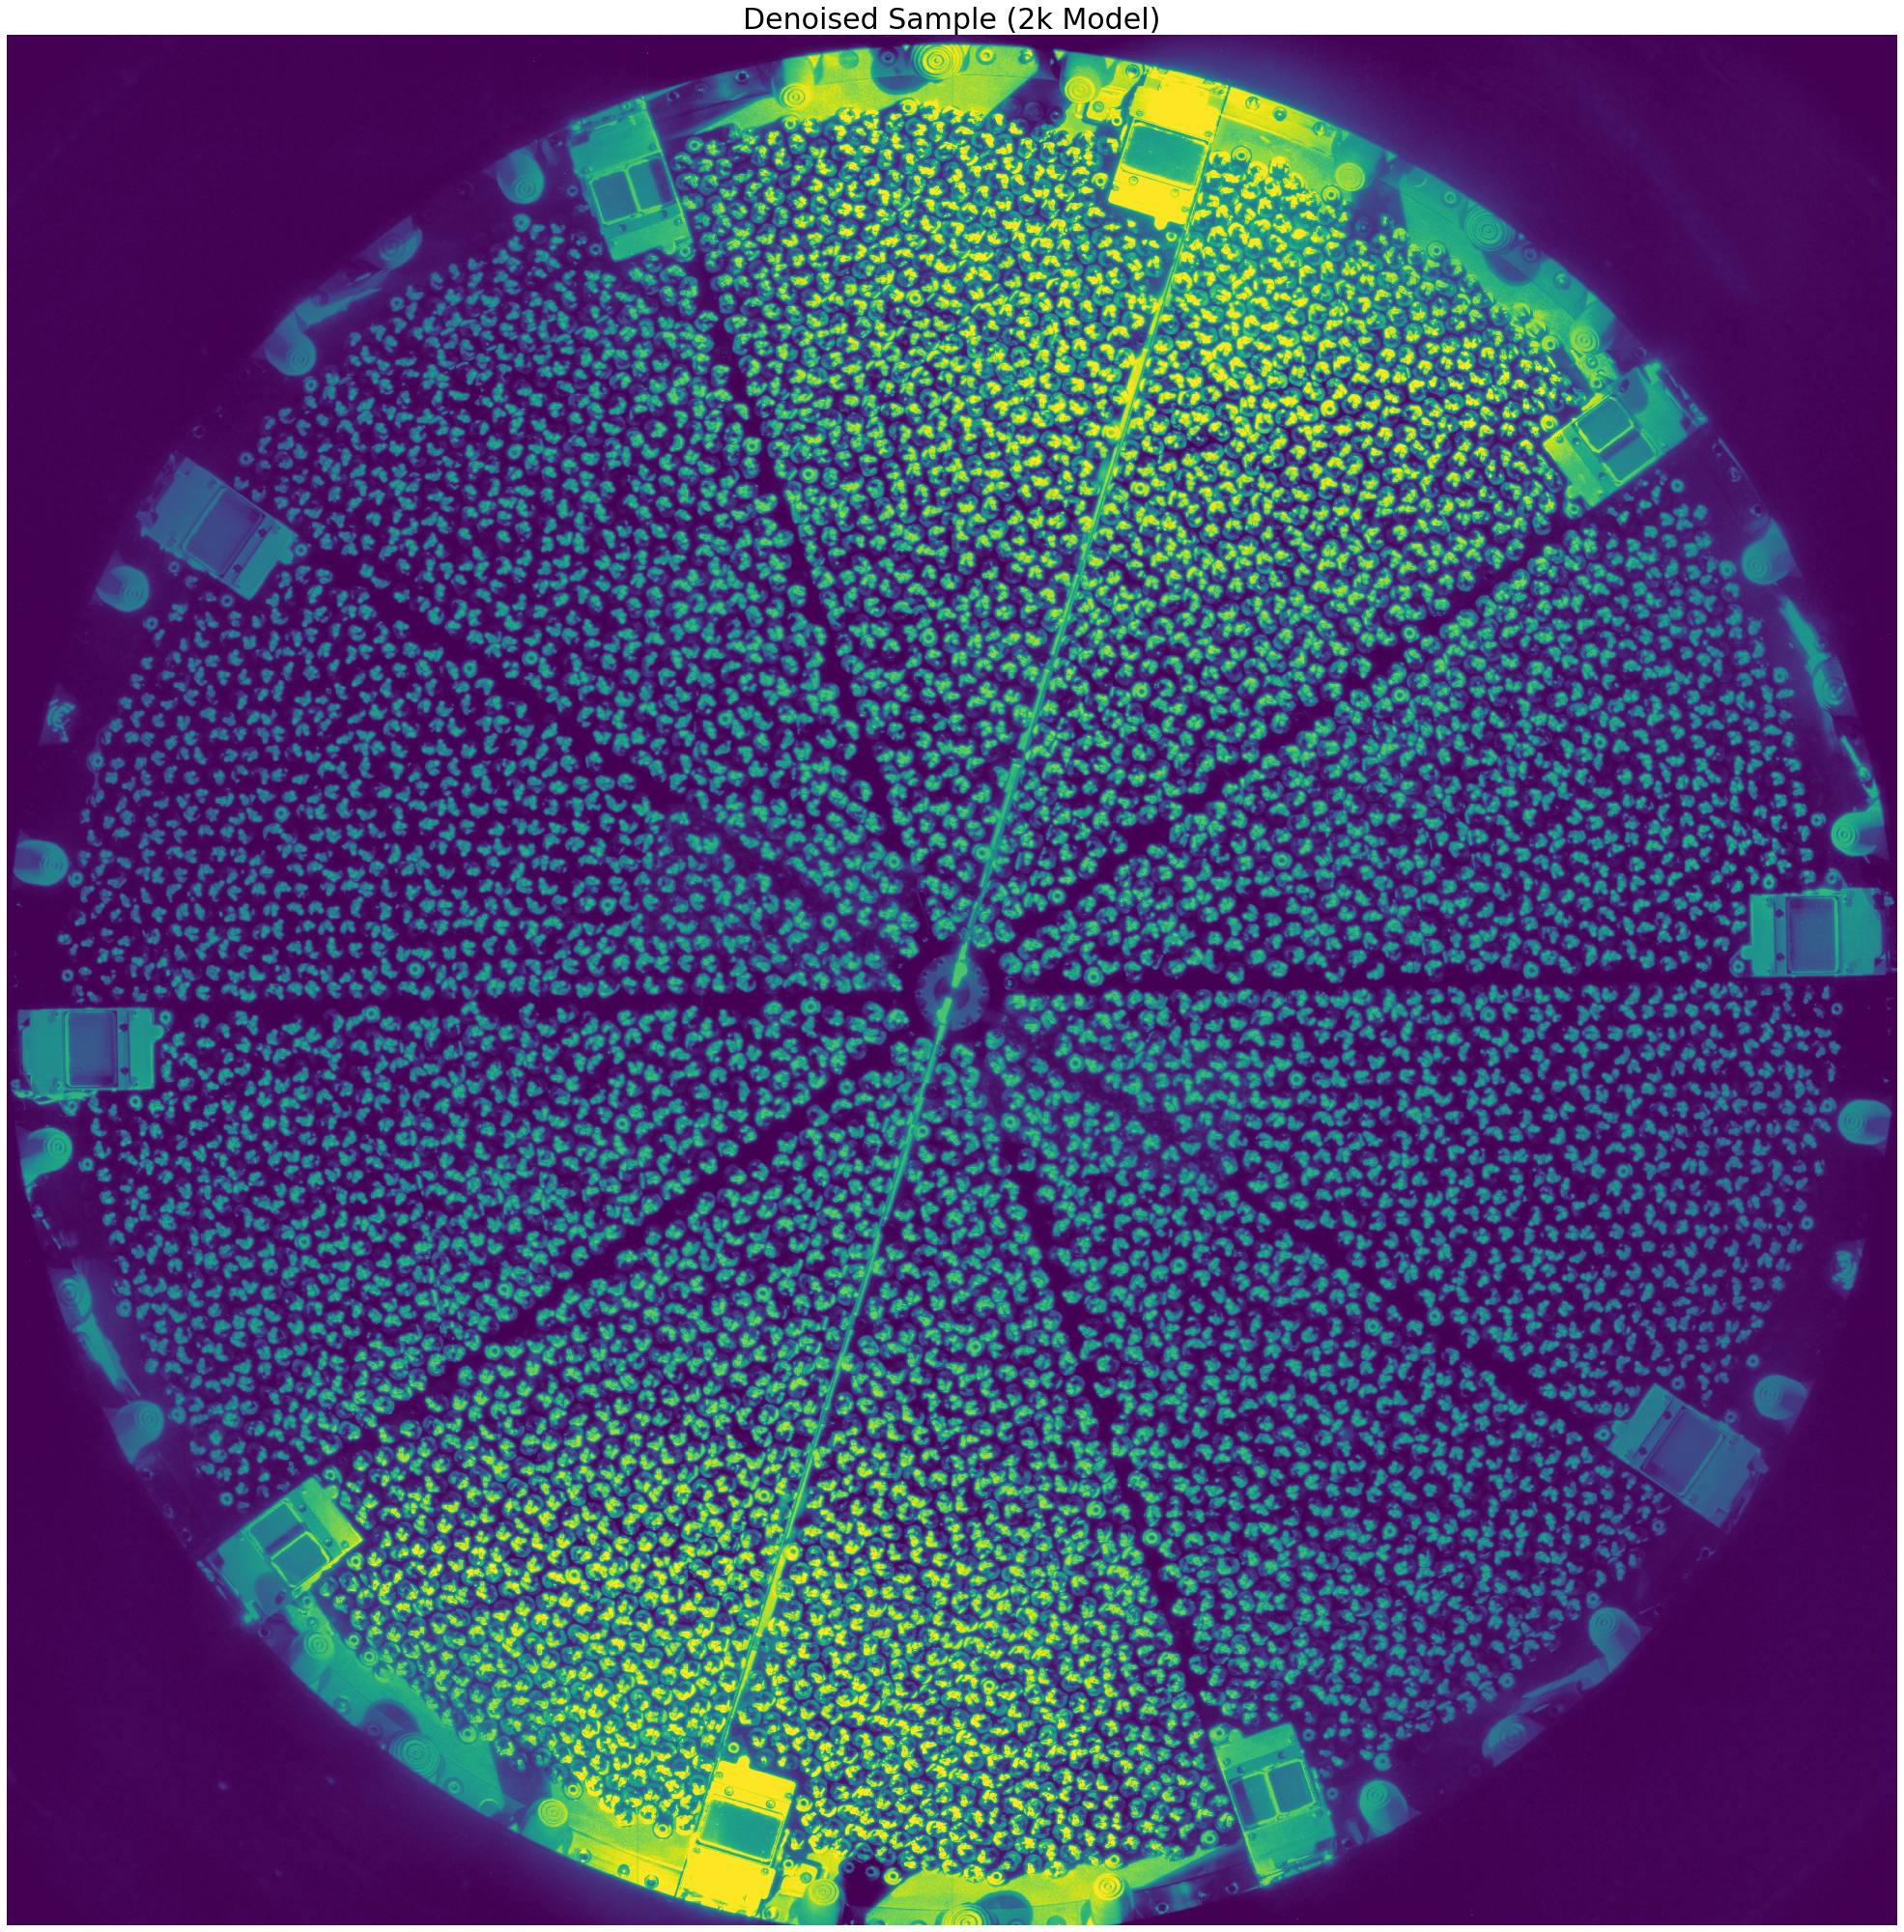

In [12]:
# full_avg = afterburner_func(dataset=data_6k,
#                             model=DnCNN_B,
#                             model_params="2k_model_bs64_e800_ps50_Adam.pth",
#                             samp_idx=0,
#                             window_size=4000,
#                             window_move_dist=1000)

fig, ax = plt.subplots(1, 1, figsize=(40,36))
vmin, vmax = np.percentile(data_6k[0][0][0], (1,99))

ax.imshow(full_avg[0][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax.axis('off')
ax.set_title('Denoised Sample (2k Model)', fontsize=30)

In [10]:
def plot_comparison(raw_data,
                    inf_data,
                    size,
                    start_idx,
                    end_idx):
    
    data_6k = raw_data
    full_img_inf = inf_data
    
    assert size == end_idx-start_idx
    
    
    fig, ax = plt.subplots(1, 3, figsize=(24,20))
    vmin, vmax = np.percentile(data_6k[0][0][0][start_idx:end_idx,start_idx:end_idx], (1,99))


    ax[0].imshow(data_6k[0][0][0][start_idx:end_idx,start_idx:end_idx], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Noisy Sample', fontsize=30)
    ax[1].imshow(full_img_inf[0][0][start_idx:end_idx,start_idx:end_idx],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Denoised Sample', fontsize=30)
    ax[2].imshow(data_6k[1][0][0][start_idx:end_idx,start_idx:end_idx], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Truth Sample', fontsize=30)

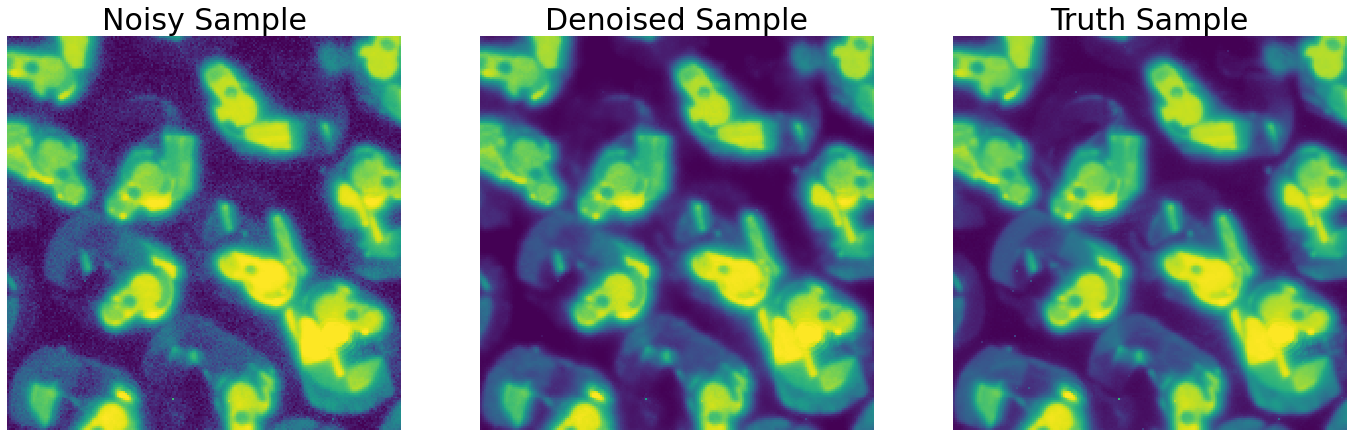

In [11]:
plot_comparison(raw_data=data_6k,
                inf_data=full_avg,
                size=200,
                start_idx=1400,
                end_idx=1600)

In [ ]:
plot_comparison(raw_data=data_6k,
                inf_data=full_avg,
                size=200,
                start_idx=2400,
                end_idx=2600)

In [ ]:
plot_comparison(raw_data=data_6k,
                inf_data=full_avg,
                size=200,
                start_idx=3400,
                end_idx=3600)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
vmin, vmax = np.percentile(data_6k[0][0][0][1400:1600, 1400:1600], (1,99))

ax.imshow(full_avg[0][0][1400:1600, 1400:1600], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax.axis('off')
ax.set_title('Denoised Sample (2k Model)', fontsize=30)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
vmin, vmax = np.percentile(data_6k[0][0][0][2400:2600, 2400:2600], (1,99))

ax.imshow(full_avg[0][0][2400:2600, 2400:2600], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
ax.axis('off')
ax.set_title('Denoised Sample (2k Model)', fontsize=30)

In [ ]:
sl.NERSC_save('2k_img_inf_WB500.npy', full_avg)

In [ ]:
%timeit full_avg = afterburner_func(dataset=data_6k, model=DnCNN_B, model_params="2k_model_bs64_e800_ps50_Adam.pth", samp_idx=0, window_size=2000, window_move_dist=1000)